# Word Meaning
Do the meanings of words used in the political discourse change over time, can we quantify this?

In [65]:
import pandas as pd
import os
import sys
import json
import re
import random
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from collections import Counter, defaultdict
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

stop_words = set(stopwords.words('english')) 
stop_words = stop_words.union(set(['ladies', 'gentlemen']))

In [43]:
# Add repo
git_dir = os.path.abspath('../')
sys.path.append(os.path.join(git_dir, 'lib', 'utils') )

# Define data output path
transcript_path = os.path.join(git_dir, 'data', 'pm-transcripts-processed/aggregated-spellfixed-typed.csv')

fig_dir = os.path.join(git_dir, 'figs')

#Read in, make string lists into strings
df_raw = pd.read_csv(transcript_path)
df_raw['sentences'] = df_raw['sentences'].map(eval)
df_raw['date'] = pd.to_datetime(df_raw['date'])

In [44]:
# All other types dont have enough structure.
release_types = ['Media Releases', 'Speech']
df = df_raw[df_raw['type'].isin(release_types)].drop('Unnamed: 0', axis=1)

In [45]:
# Baseline language data
flat_corpus = ' '.join(df.sentences.sum())
token_corpus = word_tokenize(flat_corpus)
token_corpus_filtered = [w for w in token_corpus if not w in stop_words]
corpus_freqs = Counter(token_corpus_filtered)
most_common = corpus_freqs.most_common(300)
corpus_norm = len(token_corpus_filtered)

In [46]:
woi = {
    'ind': ['aboriginal', 'first nations', 'aborigine', 'indigenous', 'torres strait island'],
    'econ': ['economy', 'economic'],
    'aus': ['australia', 'australian', 'aussie', 'australians'],
    'gov': ['government'],
    'ref': ['immigrant', 'asylum seeker', 'boat people', 'illegal arrivals', 'boat arrivals'],
    'env': ['fire', 'bushfire', 'climate change', 'climate action', 'extinction', 'global warming', 'greenhouse', 'emissions', 'environment', 'coral reef', 'reef', 'climate', 'degradation', 'sustainability']
}

In [ ]:
def fuzzy_colocation(sequences, search_key):
    ret = []
    for index, sequence in enumerate(sequences):
        if any([len(find_near_matches(subsequence, sequence, max_l_dist=2)) > 0 
             for subsequence in search_key]):
            ret.append(index)
        # Return neighbour indicies?
    return ret

def find_colocation_neighbours(idxs_in, size, dist = 1):
    idxs = idxs_in.copy()
    for idx in idxs:
        for d in range(dist):
            if not idx - d < 0:
                idxs.append(idx-d) 
            if not idx + d > size:
                idxs.append(idx+d)
    return list(set(idxs))

In [199]:
df['counters'] = df['sentences'].map(co_location)

In [200]:
df['year'] = pd.DatetimeIndex(df['date']).year

In [201]:
cofreq = df.groupby('year')['counters'].sum()

In [209]:
total_freqs = cofreq.sum().most_common(10)

In [210]:
plots = defaultdict(list)
for y in cofreq.index:
    year_count = cofreq.loc[y]
    for w, c in total_freqs:
        plots[w].append(year_count.get(w, 0))

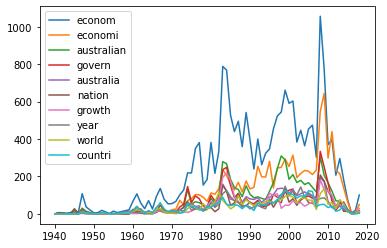

In [211]:
for x in plots:
    plt.plot(cofreq.index, plots[x])
    plt.legend(plots.keys())